In [1]:
import torch
import numpy as np
from inference import predict_from_checkpoint
from finpak.data.fetchers.yahoo import download_multiple_tickers
from preprocessing import combine_price_series

from configs import all_configs
from ticker_configs import val_tickers_v3

In [2]:
start_date = '1990-01-01'
end_date = '2024-11-15'    

# Download historical data for the tickers
data_df = download_multiple_tickers(val_tickers_v3, start_date, end_date)
data_df = data_df.loc[:,'Adj Close'] # Extract from multi-index dataframe

# Extract price series for all tickers and convert to tensors
price_series_list = []
for ticker in val_tickers_v3:
    prices = data_df[ticker]
    price_tensor = torch.tensor(prices.to_numpy(), dtype=torch.float32)
    price_series_list.append(price_tensor)

# Combine price series
combined_prices = combine_price_series(price_series_list)

[*********************100%***********************]  10 of 10 completed


In [3]:
all_configs.keys()

dict_keys(['vMS0001', 'vMS0002', 'vMS0003', 'vMS0003a', 'vMS0003b', 'vMS0003c', 'vMS0003d', 'vMS0004a', 'vMS0004b', 'test_fourier', 'v0', 'v000', 'v001', 'v002', 'v003', 'v004', 'v005', 'v005a', 'v006', 'v007', 'v008', 'v1', 'v1a', 'v1b', 'v2', 'vMP001a', 'vMP002a', 'vMP003a', 'vMP003b', 'vMP003c', 'vMP003d'])

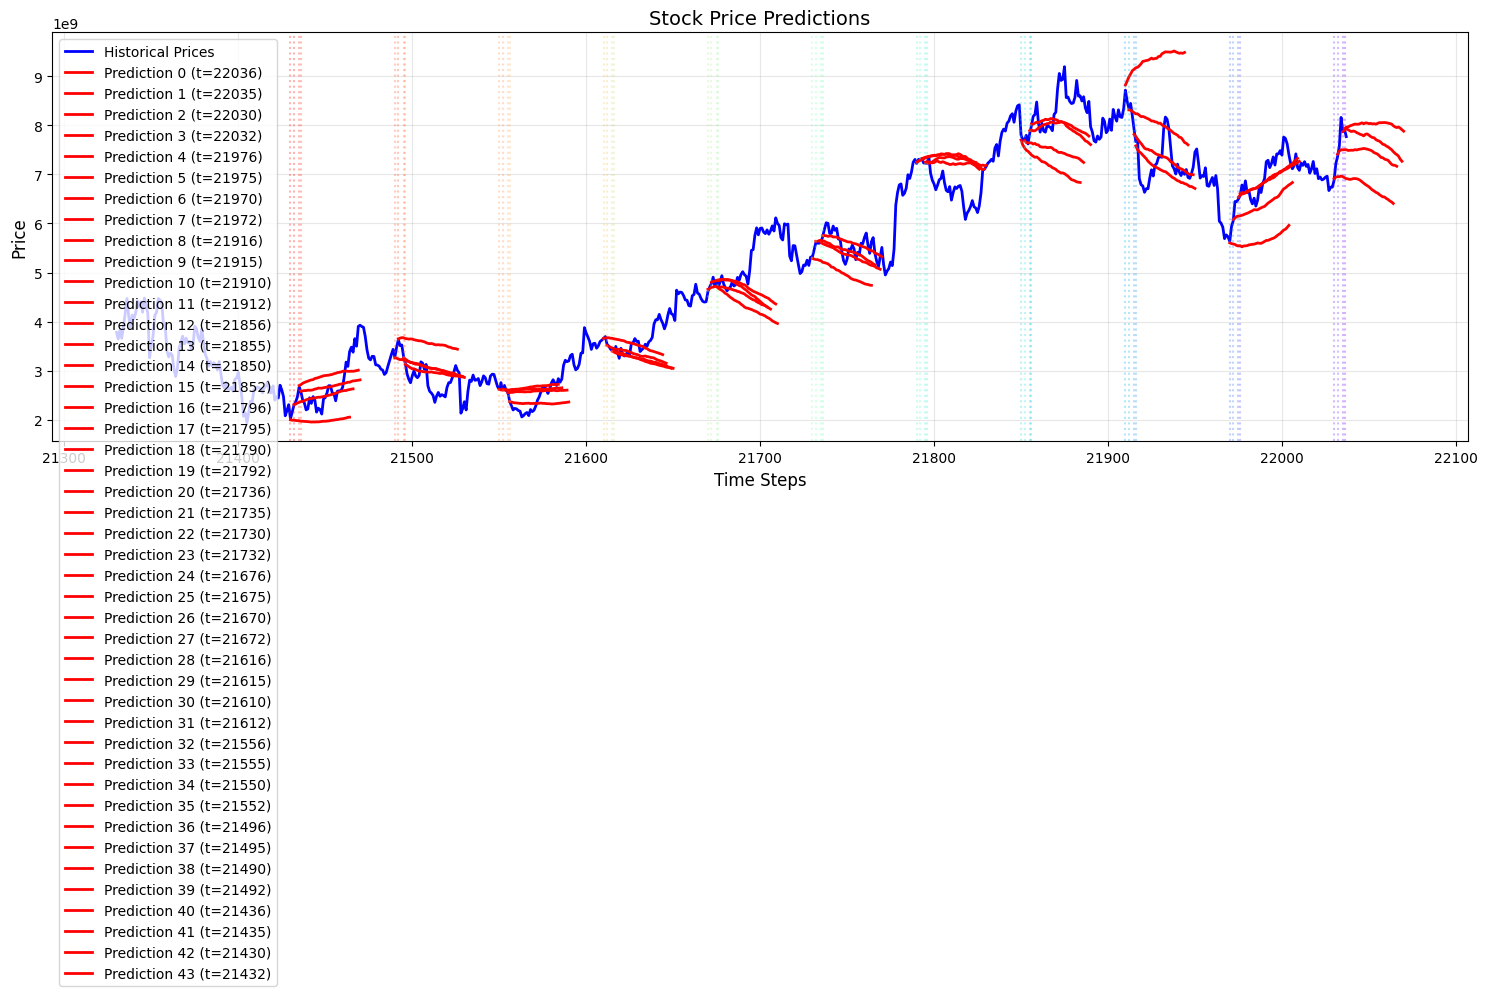

In [9]:
# ============= User-Configurable Parameters =============
# Model Selection
CONFIG_NAME = 'vMP003d'
CHECKPOINT_PATH = 'checkpoints/vMP003d_id_0_arc_v3_tc6_vc2_e338_valloss_0.0020710.pt' # 

# RECORD OF GOOD CHECKPOINTS DON"T DELETE
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003d_id_0_arc_v3_tc6_vc2_e338_valloss_0.0020710.pt' # excellent with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01# 
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003d_id_0_arc_v3_tc7_vc3_e353_valloss_0.0021448.pt' # excellent with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003c_id_0_arc_v3_tc19_vc8_e411_valloss_0.0024866.pt' # good with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003c_id_0_arc_v3_tc20_vc9_e425_valloss_0.0053009.pt' # good with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003b_id_1_arc_v3_tc9_vc7_e441_valloss_0.0005869.pt' # seems good with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003b_id_0_arc_v3_tc7_vc6_e326_valloss_0.0003369.pt' # excellent with stability_threshold 0.02, dampening_factor 0.9, ewma_alpha 0.65, temp 0.01
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt' # input features only 10?
# CHECKPOINT_PATH = 'saved_checkpoints/vMP003b_id_0_arc_v3_tc4_vc3_e252_valloss_0.0021478.pt' # ok with multihorizon

# Prediction Parameters
N_FUTURE_STEPS = 35
USE_SAMPLING = True
TEMPERATURE = 0.01  # Controls prediction randomness (higher = more random)

# Stability Parameters
STABILITY_THRESHOLD = 0.02 # 0.015  # Max allowed daily return (decrease for more stability)
DAMPENING_FACTOR = 0.9  #   0.65    # Price dampening (decrease for more stability)
EWMA_ALPHA = 0.65 # 0.2          # Price smoothing (decrease for more stability)

# Multi-horizon Parameters
USE_MULTI_HORIZON = True # False # Ideally set to True
HORIZON_WEIGHTS = None     # Optional: e.g. [0.5, 0.5] to weight different prediction horizons

# Teacher Forcing Parameters
USE_FORCING = False
FORCING_HALFLIFE = 3.0

# Index Generation Parameters
TOP_LEVEL_INDICES = np.arange(0, 660, 60).tolist()
OFFSET_STEPS = [-1, -2, -3 -4, -5] # [-5, -10, -15, -20, -25]

# ============= Config-Derived Parameters =============
# Load config
CONFIG = all_configs[CONFIG_NAME]
MODEL_PARAMS = CONFIG['model_params'].copy()
MODEL_PARAMS.pop('dropout', None)  # Remove dropout for inference

# Get sequence and feature parameters from config
sequence_length = CONFIG['data_params']['sequence_length']
return_periods = CONFIG['data_params']['return_periods']
sma_periods = CONFIG['data_params']['sma_periods']
target_periods = CONFIG['data_params']['target_periods']
momentum_periods = CONFIG['data_params']['momentum_periods']

# Calculate input dimension
d_input = 0
d_input += len(return_periods)  # Return features
d_input += len(sma_periods)     # SMA features
if CONFIG['data_params']['use_momentum']:
    d_input += len(CONFIG['data_params']['momentum_periods'])
if CONFIG['data_params']['use_volatility']:
    d_input += len(return_periods)

# Calculate output dimension
n_outputs = len(target_periods)

# Update model parameters
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs

# ============= Index Generation =============
# Calculate required history
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(momentum_periods) if momentum_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Find last valid index
last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Generate valid start indices
start_indices = []
for base_idx in TOP_LEVEL_INDICES:
    for offset in OFFSET_STEPS:
        idx = last_valid_idx - (base_idx + abs(offset))
        if idx >= total_required_history:
            start_indices.append(idx)

# ============= Make Predictions =============
predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=N_FUTURE_STEPS,
    config=CONFIG,
    model_params=MODEL_PARAMS,
    use_multi_horizon=USE_MULTI_HORIZON,
    stability_threshold=STABILITY_THRESHOLD,  # Max % daily move - decrease for more stability
    dampening_factor=DAMPENING_FACTOR,  # Stronger dampening - decrease for more stability
    ewma_alpha=EWMA_ALPHA,  # More smoothing - decrease for more stability
    horizon_weights=HORIZON_WEIGHTS, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=USE_FORCING,
    forcing_halflife=FORCING_HALFLIFE,
    temperature=TEMPERATURE,
    use_sampling=USE_SAMPLING,
    debug=False,
)

In [5]:
# # # Get the last valid index
# last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()
# # INDICES = [550, 545, 540, 400, 395, 390, 300, 295, 290, 250, 245, 240, 200, 195, 190, 100, 95, 90, 50, 45, 40, 10, 5, 0] # [50, 10, 5]
# # INDICES = [x + 100 for x in INDICES]
# TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist() # 800
# INDICES = []
# for idx in TOP_LEVEL_INDICES:
#     INDICES.extend([idx - 5, idx - 10, idx - 15, idx - 20, idx - 25])
# start_indices = [last_valid_idx - ix for ix in INDICES]

n_future_steps = 35
use_sampling = True
temperature = 0.01 # 0.08
CONFIG = all_configs['vMP003a']
sequence_length = CONFIG['data_params']['sequence_length']
MODEL_PARAMS = CONFIG['model_params']
MODEL_PARAMS.pop('dropout', None)

# Add these to model params
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs


CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt'
# Decent models
# CHECKPOINT_PATH = 'saved_checkpoints/vMP001a_id_0_arc_v3_e277_valloss_0.0004595.pt'
# CHECKPOINT_PATH = 'vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'
# CHECKPOINT_PATH = 'saved_checkpoints/vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'

# Calculate input dimension based on config
n_return_features = len(CONFIG['data_params']['return_periods'])
n_sma_features = len(CONFIG['data_params']['sma_periods'])
n_momentum_features = len(CONFIG['data_params']['momentum_periods']) if CONFIG['data_params']['use_momentum'] else 0
n_volatility_features = 1 if CONFIG['data_params']['use_volatility'] else 0
d_input = n_return_features + n_sma_features #+ n_momentum_features + n_volatility_features
sma_periods = CONFIG['data_params']['sma_periods']
return_periods = CONFIG['data_params']['return_periods']
target_periods = CONFIG['data_params']['target_periods']

# Output dimension is number of target periods
n_outputs = len(CONFIG['data_params']['target_periods'])

last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Calculate required history
sequence_length = CONFIG['data_params']['sequence_length']  # Make sure this matches your model's sequence_length
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Generate indices ensuring enough history
TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist()
offsets = [-5, -10, -15, -20, -25]
INDICES = []
for base_idx in TOP_LEVEL_INDICES:
    # Calculate the actual offset from the last valid index
    for offset in offsets:
        idx = last_valid_idx - (base_idx + abs(offset))
        # Only add if we have enough history
        if idx >= total_required_history:
            INDICES.append(idx)
start_indices = [last_valid_idx - ix for ix in INDICES]


predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=n_future_steps,
    model_params=MODEL_PARAMS,
    sequence_length=sequence_length,
    return_periods=CONFIG['data_params']['return_periods'],
    sma_periods=CONFIG['data_params']['sma_periods'],
    use_multi_horizon=True,
    stability_threshold=0.015, # Max % daily move - decrease for more stability
    dampening_factor=0.65,  # Stronger dampening - decrease for more stability
    ewma_alpha=0.2,  # More smoothing - decrease for more stability
    horizon_weights=None, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=False, # True,
    forcing_halflife=3.0,
    temperature=temperature,
    use_sampling=use_sampling,
    debug=False,
)


TypeError: predict_from_checkpoint() got an unexpected keyword argument 'sequence_length'

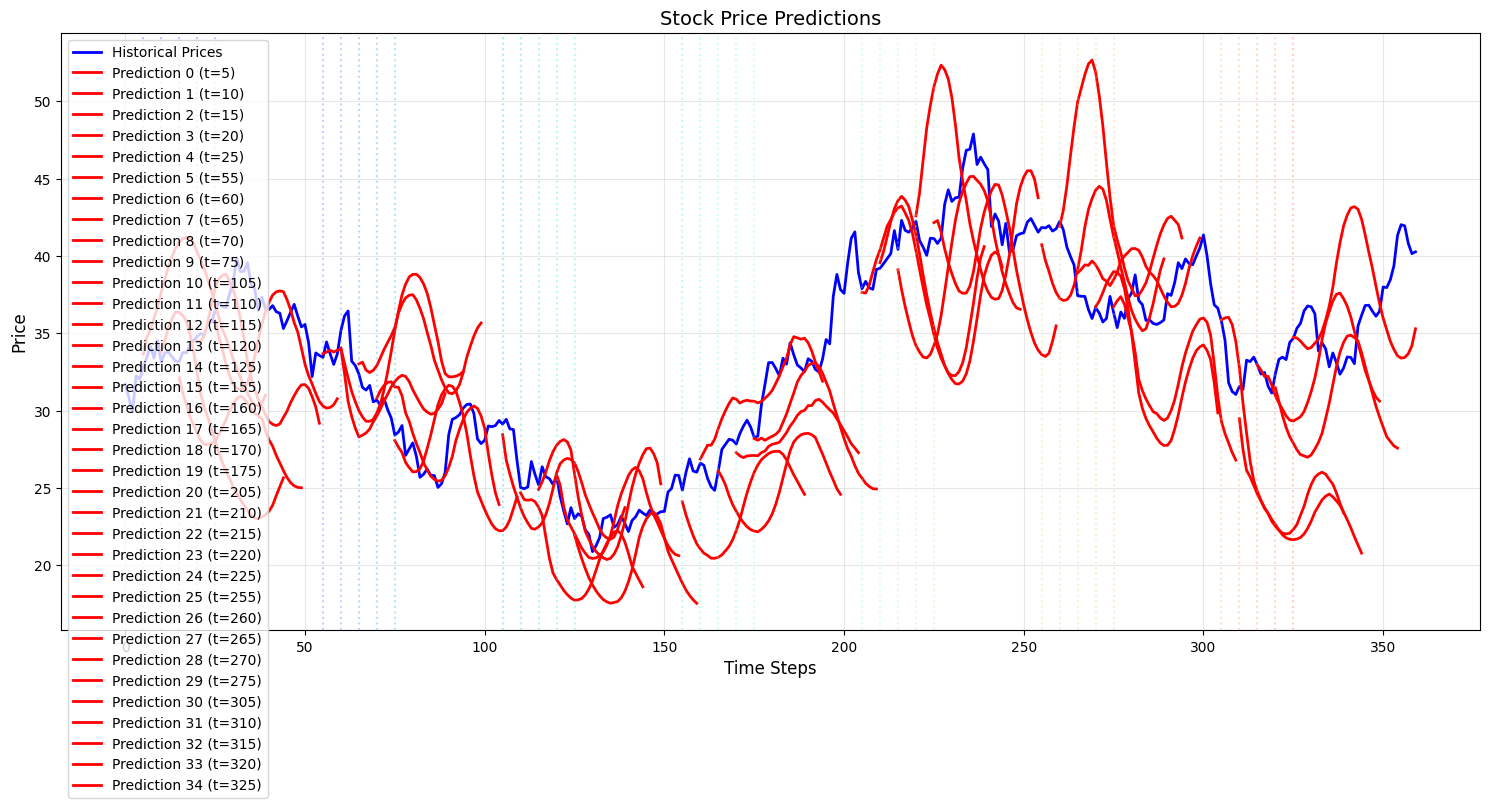

In [ ]:
# # # Get the last valid index
# last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()
# # INDICES = [550, 545, 540, 400, 395, 390, 300, 295, 290, 250, 245, 240, 200, 195, 190, 100, 95, 90, 50, 45, 40, 10, 5, 0] # [50, 10, 5]
# # INDICES = [x + 100 for x in INDICES]
# TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist() # 800
# INDICES = []
# for idx in TOP_LEVEL_INDICES:
#     INDICES.extend([idx - 5, idx - 10, idx - 15, idx - 20, idx - 25])
# start_indices = [last_valid_idx - ix for ix in INDICES]

n_future_steps = 35
use_sampling = True
temperature = 0.01 # 0.08
CONFIG = all_configs['vMP003a']
sequence_length = CONFIG['data_params']['sequence_length']
MODEL_PARAMS = CONFIG['model_params']
MODEL_PARAMS.pop('dropout', None)

# Add these to model params
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs


CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt'
# Decent models
# CHECKPOINT_PATH = 'saved_checkpoints/vMP001a_id_0_arc_v3_e277_valloss_0.0004595.pt'
# CHECKPOINT_PATH = 'vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'
# CHECKPOINT_PATH = 'saved_checkpoints/vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'

# Calculate input dimension based on config
n_return_features = len(CONFIG['data_params']['return_periods'])
n_sma_features = len(CONFIG['data_params']['sma_periods'])
n_momentum_features = len(CONFIG['data_params']['momentum_periods']) if CONFIG['data_params']['use_momentum'] else 0
n_volatility_features = 1 if CONFIG['data_params']['use_volatility'] else 0
d_input = n_return_features + n_sma_features #+ n_momentum_features + n_volatility_features
sma_periods = CONFIG['data_params']['sma_periods']
return_periods = CONFIG['data_params']['return_periods']
target_periods = CONFIG['data_params']['target_periods']

# Output dimension is number of target periods
n_outputs = len(CONFIG['data_params']['target_periods'])

last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Calculate required history
sequence_length = CONFIG['data_params']['sequence_length']  # Make sure this matches your model's sequence_length
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Generate indices ensuring enough history
TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist()
offsets = [-5, -10, -15, -20, -25]
INDICES = []
for base_idx in TOP_LEVEL_INDICES:
    # Calculate the actual offset from the last valid index
    for offset in offsets:
        idx = last_valid_idx - (base_idx + abs(offset))
        # Only add if we have enough history
        if idx >= total_required_history:
            INDICES.append(idx)
start_indices = [last_valid_idx - ix for ix in INDICES]


predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=n_future_steps,
    model_params=MODEL_PARAMS,
    sequence_length=sequence_length,
    return_periods=CONFIG['data_params']['return_periods'],
    sma_periods=CONFIG['data_params']['sma_periods'],
    use_multi_horizon=True,
    stability_threshold=0.015, # Max % daily move - decrease for more stability
    dampening_factor=0.65,  # Stronger dampening - decrease for more stability
    ewma_alpha=0.2,  # More smoothing - decrease for more stability
    horizon_weights=None, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=False, # True,
    forcing_halflife=3.0,
    temperature=temperature,
    use_sampling=use_sampling,
    debug=False,
)


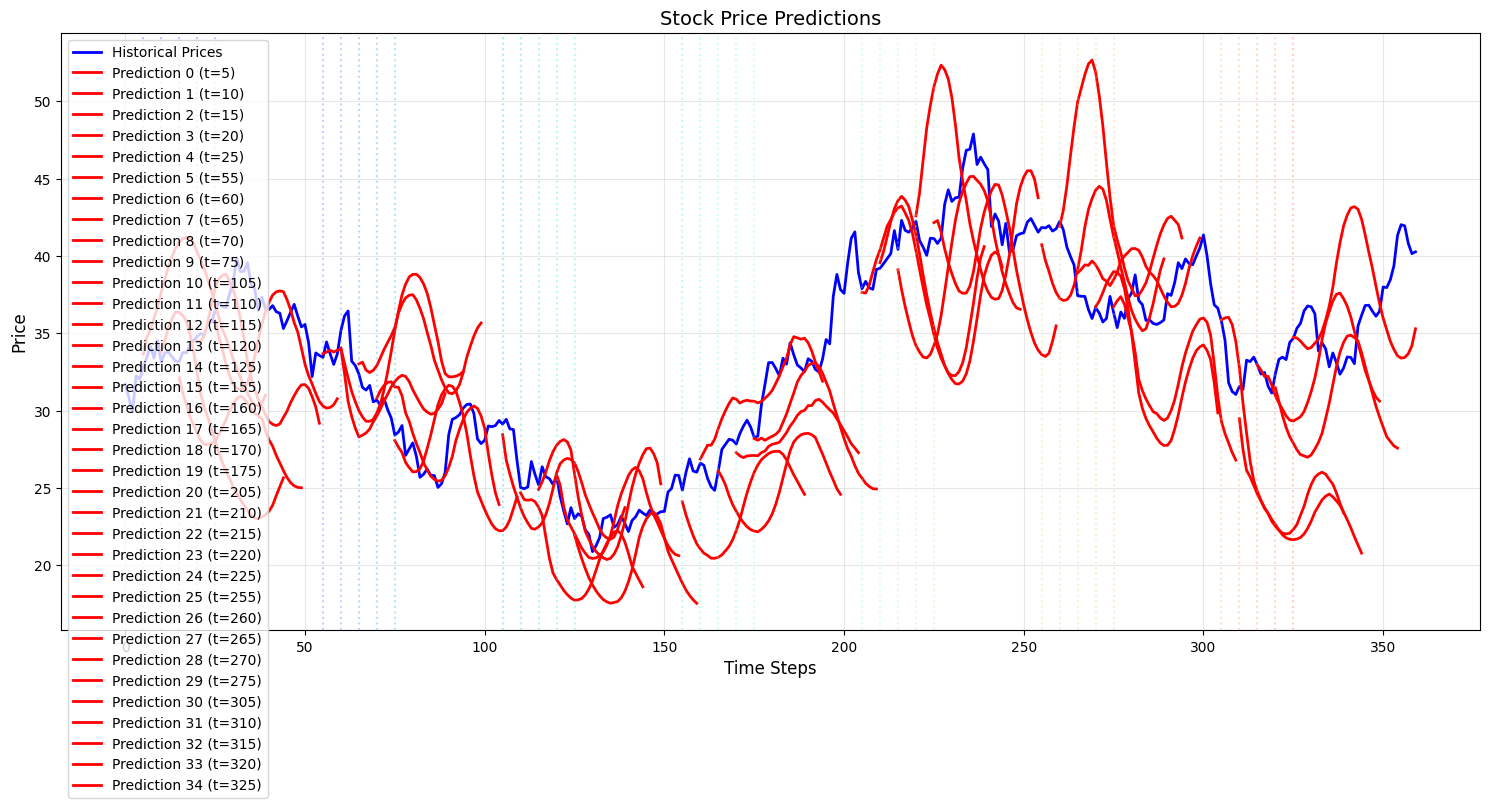

In [ ]:
# # # Get the last valid index
# last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()
# # INDICES = [550, 545, 540, 400, 395, 390, 300, 295, 290, 250, 245, 240, 200, 195, 190, 100, 95, 90, 50, 45, 40, 10, 5, 0] # [50, 10, 5]
# # INDICES = [x + 100 for x in INDICES]
# TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist() # 800
# INDICES = []
# for idx in TOP_LEVEL_INDICES:
#     INDICES.extend([idx - 5, idx - 10, idx - 15, idx - 20, idx - 25])
# start_indices = [last_valid_idx - ix for ix in INDICES]

n_future_steps = 35
use_sampling = True
temperature = 0.01 # 0.08
CONFIG = all_configs['vMP003a']
sequence_length = CONFIG['data_params']['sequence_length']
MODEL_PARAMS = CONFIG['model_params']
MODEL_PARAMS.pop('dropout', None)

# Add these to model params
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs


CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt'
# Decent models
# CHECKPOINT_PATH = 'saved_checkpoints/vMP001a_id_0_arc_v3_e277_valloss_0.0004595.pt'
# CHECKPOINT_PATH = 'vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'
# CHECKPOINT_PATH = 'saved_checkpoints/vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'

# Calculate input dimension based on config
n_return_features = len(CONFIG['data_params']['return_periods'])
n_sma_features = len(CONFIG['data_params']['sma_periods'])
n_momentum_features = len(CONFIG['data_params']['momentum_periods']) if CONFIG['data_params']['use_momentum'] else 0
n_volatility_features = 1 if CONFIG['data_params']['use_volatility'] else 0
d_input = n_return_features + n_sma_features #+ n_momentum_features + n_volatility_features
sma_periods = CONFIG['data_params']['sma_periods']
return_periods = CONFIG['data_params']['return_periods']
target_periods = CONFIG['data_params']['target_periods']

# Output dimension is number of target periods
n_outputs = len(CONFIG['data_params']['target_periods'])

last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Calculate required history
sequence_length = CONFIG['data_params']['sequence_length']  # Make sure this matches your model's sequence_length
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Generate indices ensuring enough history
TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist()
offsets = [-5, -10, -15, -20, -25]
INDICES = []
for base_idx in TOP_LEVEL_INDICES:
    # Calculate the actual offset from the last valid index
    for offset in offsets:
        idx = last_valid_idx - (base_idx + abs(offset))
        # Only add if we have enough history
        if idx >= total_required_history:
            INDICES.append(idx)
start_indices = [last_valid_idx - ix for ix in INDICES]


predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=n_future_steps,
    model_params=MODEL_PARAMS,
    sequence_length=sequence_length,
    return_periods=CONFIG['data_params']['return_periods'],
    sma_periods=CONFIG['data_params']['sma_periods'],
    use_multi_horizon=True,
    stability_threshold=0.015, # Max % daily move - decrease for more stability
    dampening_factor=0.65,  # Stronger dampening - decrease for more stability
    ewma_alpha=0.2,  # More smoothing - decrease for more stability
    horizon_weights=None, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=False, # True,
    forcing_halflife=3.0,
    temperature=temperature,
    use_sampling=use_sampling,
    debug=False,
)


In [ ]:
# # # Get the last valid index
# last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()
# # INDICES = [550, 545, 540, 400, 395, 390, 300, 295, 290, 250, 245, 240, 200, 195, 190, 100, 95, 90, 50, 45, 40, 10, 5, 0] # [50, 10, 5]
# # INDICES = [x + 100 for x in INDICES]
# TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist() # 800
# INDICES = []
# for idx in TOP_LEVEL_INDICES:
#     INDICES.extend([idx - 5, idx - 10, idx - 15, idx - 20, idx - 25])
# start_indices = [last_valid_idx - ix for ix in INDICES]

n_future_steps = 35
use_sampling = True
temperature = 0.01 # 0.08
CONFIG = all_configs['vMP003a']
sequence_length = CONFIG['data_params']['sequence_length']
MODEL_PARAMS = CONFIG['model_params']
MODEL_PARAMS.pop('dropout', None)

# Add these to model params
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs


CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt'
# Decent models
# CHECKPOINT_PATH = 'saved_checkpoints/vMP001a_id_0_arc_v3_e277_valloss_0.0004595.pt'
# CHECKPOINT_PATH = 'vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'
# CHECKPOINT_PATH = 'saved_checkpoints/vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'

# Calculate input dimension based on config
n_return_features = len(CONFIG['data_params']['return_periods'])
n_sma_features = len(CONFIG['data_params']['sma_periods'])
n_momentum_features = len(CONFIG['data_params']['momentum_periods']) if CONFIG['data_params']['use_momentum'] else 0
n_volatility_features = 1 if CONFIG['data_params']['use_volatility'] else 0
d_input = n_return_features + n_sma_features #+ n_momentum_features + n_volatility_features
sma_periods = CONFIG['data_params']['sma_periods']
return_periods = CONFIG['data_params']['return_periods']
target_periods = CONFIG['data_params']['target_periods']

# Output dimension is number of target periods
n_outputs = len(CONFIG['data_params']['target_periods'])

last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Calculate required history
sequence_length = CONFIG['data_params']['sequence_length']  # Make sure this matches your model's sequence_length
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Generate indices ensuring enough history
TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist()
offsets = [-5, -10, -15, -20, -25]
INDICES = []
for base_idx in TOP_LEVEL_INDICES:
    # Calculate the actual offset from the last valid index
    for offset in offsets:
        idx = last_valid_idx - (base_idx + abs(offset))
        # Only add if we have enough history
        if idx >= total_required_history:
            INDICES.append(idx)
start_indices = [last_valid_idx - ix for ix in INDICES]


predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=n_future_steps,
    model_params=MODEL_PARAMS,
    sequence_length=sequence_length,
    return_periods=CONFIG['data_params']['return_periods'],
    sma_periods=CONFIG['data_params']['sma_periods'],
    use_multi_horizon=True,
    stability_threshold=0.015, # Max % daily move - decrease for more stability
    dampening_factor=0.65,  # Stronger dampening - decrease for more stability
    ewma_alpha=0.2,  # More smoothing - decrease for more stability
    horizon_weights=None, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=False, # True,
    forcing_halflife=3.0,
    temperature=temperature,
    use_sampling=use_sampling,
    debug=False,
)


In [ ]:
# # # Get the last valid index
# last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()
# # INDICES = [550, 545, 540, 400, 395, 390, 300, 295, 290, 250, 245, 240, 200, 195, 190, 100, 95, 90, 50, 45, 40, 10, 5, 0] # [50, 10, 5]
# # INDICES = [x + 100 for x in INDICES]
# TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist() # 800
# INDICES = []
# for idx in TOP_LEVEL_INDICES:
#     INDICES.extend([idx - 5, idx - 10, idx - 15, idx - 20, idx - 25])
# start_indices = [last_valid_idx - ix for ix in INDICES]

n_future_steps = 35
use_sampling = True
temperature = 0.01 # 0.08
CONFIG = all_configs['vMP003a']
sequence_length = CONFIG['data_params']['sequence_length']
MODEL_PARAMS = CONFIG['model_params']
MODEL_PARAMS.pop('dropout', None)

# Add these to model params
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs


CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt'
# Decent models
# CHECKPOINT_PATH = 'saved_checkpoints/vMP001a_id_0_arc_v3_e277_valloss_0.0004595.pt'
# CHECKPOINT_PATH = 'vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'
# CHECKPOINT_PATH = 'saved_checkpoints/vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'

# Calculate input dimension based on config
n_return_features = len(CONFIG['data_params']['return_periods'])
n_sma_features = len(CONFIG['data_params']['sma_periods'])
n_momentum_features = len(CONFIG['data_params']['momentum_periods']) if CONFIG['data_params']['use_momentum'] else 0
n_volatility_features = 1 if CONFIG['data_params']['use_volatility'] else 0
d_input = n_return_features + n_sma_features #+ n_momentum_features + n_volatility_features
sma_periods = CONFIG['data_params']['sma_periods']
return_periods = CONFIG['data_params']['return_periods']
target_periods = CONFIG['data_params']['target_periods']

# Output dimension is number of target periods
n_outputs = len(CONFIG['data_params']['target_periods'])

last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Calculate required history
sequence_length = CONFIG['data_params']['sequence_length']  # Make sure this matches your model's sequence_length
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Generate indices ensuring enough history
TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist()
offsets = [-5, -10, -15, -20, -25]
INDICES = []
for base_idx in TOP_LEVEL_INDICES:
    # Calculate the actual offset from the last valid index
    for offset in offsets:
        idx = last_valid_idx - (base_idx + abs(offset))
        # Only add if we have enough history
        if idx >= total_required_history:
            INDICES.append(idx)
start_indices = [last_valid_idx - ix for ix in INDICES]


predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=n_future_steps,
    model_params=MODEL_PARAMS,
    sequence_length=sequence_length,
    return_periods=CONFIG['data_params']['return_periods'],
    sma_periods=CONFIG['data_params']['sma_periods'],
    use_multi_horizon=True,
    stability_threshold=0.015, # Max % daily move - decrease for more stability
    dampening_factor=0.65,  # Stronger dampening - decrease for more stability
    ewma_alpha=0.2,  # More smoothing - decrease for more stability
    horizon_weights=None, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=False, # True,
    forcing_halflife=3.0,
    temperature=temperature,
    use_sampling=use_sampling,
    debug=False,
)


In [ ]:
# # # Get the last valid index
# last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()
# # INDICES = [550, 545, 540, 400, 395, 390, 300, 295, 290, 250, 245, 240, 200, 195, 190, 100, 95, 90, 50, 45, 40, 10, 5, 0] # [50, 10, 5]
# # INDICES = [x + 100 for x in INDICES]
# TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist() # 800
# INDICES = []
# for idx in TOP_LEVEL_INDICES:
#     INDICES.extend([idx - 5, idx - 10, idx - 15, idx - 20, idx - 25])
# start_indices = [last_valid_idx - ix for ix in INDICES]

n_future_steps = 35
use_sampling = True
temperature = 0.01 # 0.08
CONFIG = all_configs['vMP003a']
sequence_length = CONFIG['data_params']['sequence_length']
MODEL_PARAMS = CONFIG['model_params']
MODEL_PARAMS.pop('dropout', None)

# Add these to model params
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs


CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt'
# Decent models
# CHECKPOINT_PATH = 'saved_checkpoints/vMP001a_id_0_arc_v3_e277_valloss_0.0004595.pt'
# CHECKPOINT_PATH = 'vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'
# CHECKPOINT_PATH = 'saved_checkpoints/vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'

# Calculate input dimension based on config
n_return_features = len(CONFIG['data_params']['return_periods'])
n_sma_features = len(CONFIG['data_params']['sma_periods'])
n_momentum_features = len(CONFIG['data_params']['momentum_periods']) if CONFIG['data_params']['use_momentum'] else 0
n_volatility_features = 1 if CONFIG['data_params']['use_volatility'] else 0
d_input = n_return_features + n_sma_features #+ n_momentum_features + n_volatility_features
sma_periods = CONFIG['data_params']['sma_periods']
return_periods = CONFIG['data_params']['return_periods']
target_periods = CONFIG['data_params']['target_periods']

# Output dimension is number of target periods
n_outputs = len(CONFIG['data_params']['target_periods'])

last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Calculate required history
sequence_length = CONFIG['data_params']['sequence_length']  # Make sure this matches your model's sequence_length
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Generate indices ensuring enough history
TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist()
offsets = [-5, -10, -15, -20, -25]
INDICES = []
for base_idx in TOP_LEVEL_INDICES:
    # Calculate the actual offset from the last valid index
    for offset in offsets:
        idx = last_valid_idx - (base_idx + abs(offset))
        # Only add if we have enough history
        if idx >= total_required_history:
            INDICES.append(idx)
start_indices = [last_valid_idx - ix for ix in INDICES]


predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=n_future_steps,
    model_params=MODEL_PARAMS,
    sequence_length=sequence_length,
    return_periods=CONFIG['data_params']['return_periods'],
    sma_periods=CONFIG['data_params']['sma_periods'],
    use_multi_horizon=True,
    stability_threshold=0.015, # Max % daily move - decrease for more stability
    dampening_factor=0.65,  # Stronger dampening - decrease for more stability
    ewma_alpha=0.2,  # More smoothing - decrease for more stability
    horizon_weights=None, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=False, # True,
    forcing_halflife=3.0,
    temperature=temperature,
    use_sampling=use_sampling,
    debug=False,
)


In [ ]:
# # # Get the last valid index
# last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()
# # INDICES = [550, 545, 540, 400, 395, 390, 300, 295, 290, 250, 245, 240, 200, 195, 190, 100, 95, 90, 50, 45, 40, 10, 5, 0] # [50, 10, 5]
# # INDICES = [x + 100 for x in INDICES]
# TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist() # 800
# INDICES = []
# for idx in TOP_LEVEL_INDICES:
#     INDICES.extend([idx - 5, idx - 10, idx - 15, idx - 20, idx - 25])
# start_indices = [last_valid_idx - ix for ix in INDICES]

n_future_steps = 35
use_sampling = True
temperature = 0.01 # 0.08
CONFIG = all_configs['vMP003a']
sequence_length = CONFIG['data_params']['sequence_length']
MODEL_PARAMS = CONFIG['model_params']
MODEL_PARAMS.pop('dropout', None)

# Add these to model params
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs


CHECKPOINT_PATH = 'saved_checkpoints/vMP003a_id_0_arc_v3_tc8_vc4_e413_valloss_0.0009714.pt'
# Decent models
# CHECKPOINT_PATH = 'saved_checkpoints/vMP001a_id_0_arc_v3_e277_valloss_0.0004595.pt'
# CHECKPOINT_PATH = 'vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'
# CHECKPOINT_PATH = 'saved_checkpoints/vMP002a_final_id_1_arc_v3_e633_valloss_0.0059124.pt'

# Calculate input dimension based on config
n_return_features = len(CONFIG['data_params']['return_periods'])
n_sma_features = len(CONFIG['data_params']['sma_periods'])
n_momentum_features = len(CONFIG['data_params']['momentum_periods']) if CONFIG['data_params']['use_momentum'] else 0
n_volatility_features = 1 if CONFIG['data_params']['use_volatility'] else 0
d_input = n_return_features + n_sma_features #+ n_momentum_features + n_volatility_features
sma_periods = CONFIG['data_params']['sma_periods']
return_periods = CONFIG['data_params']['return_periods']
target_periods = CONFIG['data_params']['target_periods']

# Output dimension is number of target periods
n_outputs = len(CONFIG['data_params']['target_periods'])

last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Calculate required history
sequence_length = CONFIG['data_params']['sequence_length']  # Make sure this matches your model's sequence_length
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Generate indices ensuring enough history
TOP_LEVEL_INDICES = np.arange(0, 400, 50).tolist()
offsets = [-5, -10, -15, -20, -25]
INDICES = []
for base_idx in TOP_LEVEL_INDICES:
    # Calculate the actual offset from the last valid index
    for offset in offsets:
        idx = last_valid_idx - (base_idx + abs(offset))
        # Only add if we have enough history
        if idx >= total_required_history:
            INDICES.append(idx)
start_indices = [last_valid_idx - ix for ix in INDICES]


predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices,
    start_indices=start_indices,
    n_steps=n_future_steps,
    model_params=MODEL_PARAMS,
    sequence_length=sequence_length,
    return_periods=CONFIG['data_params']['return_periods'],
    sma_periods=CONFIG['data_params']['sma_periods'],
    use_multi_horizon=True,
    stability_threshold=0.015, # Max % daily move - decrease for more stability
    dampening_factor=0.65,  # Stronger dampening - decrease for more stability
    ewma_alpha=0.2,  # More smoothing - decrease for more stability
    horizon_weights=None, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=False, # True,
    forcing_halflife=3.0,
    temperature=temperature,
    use_sampling=use_sampling,
    debug=False,
)


In [5]:
len(combined_prices), last_valid_idx

(21961, 21960)

In [ ]:
len(combined_prices), last_valid_idx

NameError: name 'last_valid_idx' is not defined

In [8]:
len(combined_prices), last_valid_idx

(22038, 22037)

temp:

In [5]:
MODEL_PARAMS

{'d_model': 256,
 'n_heads': 8,
 'n_layers': 16,
 'd_ff': 512,
 'use_multi_scale': False,
 'use_relative_pos': False,
 'temporal_scales': [1, 4, 6],
 'd_input': 6,
 'n_outputs': 5}

Using 1-day horizon weights only:
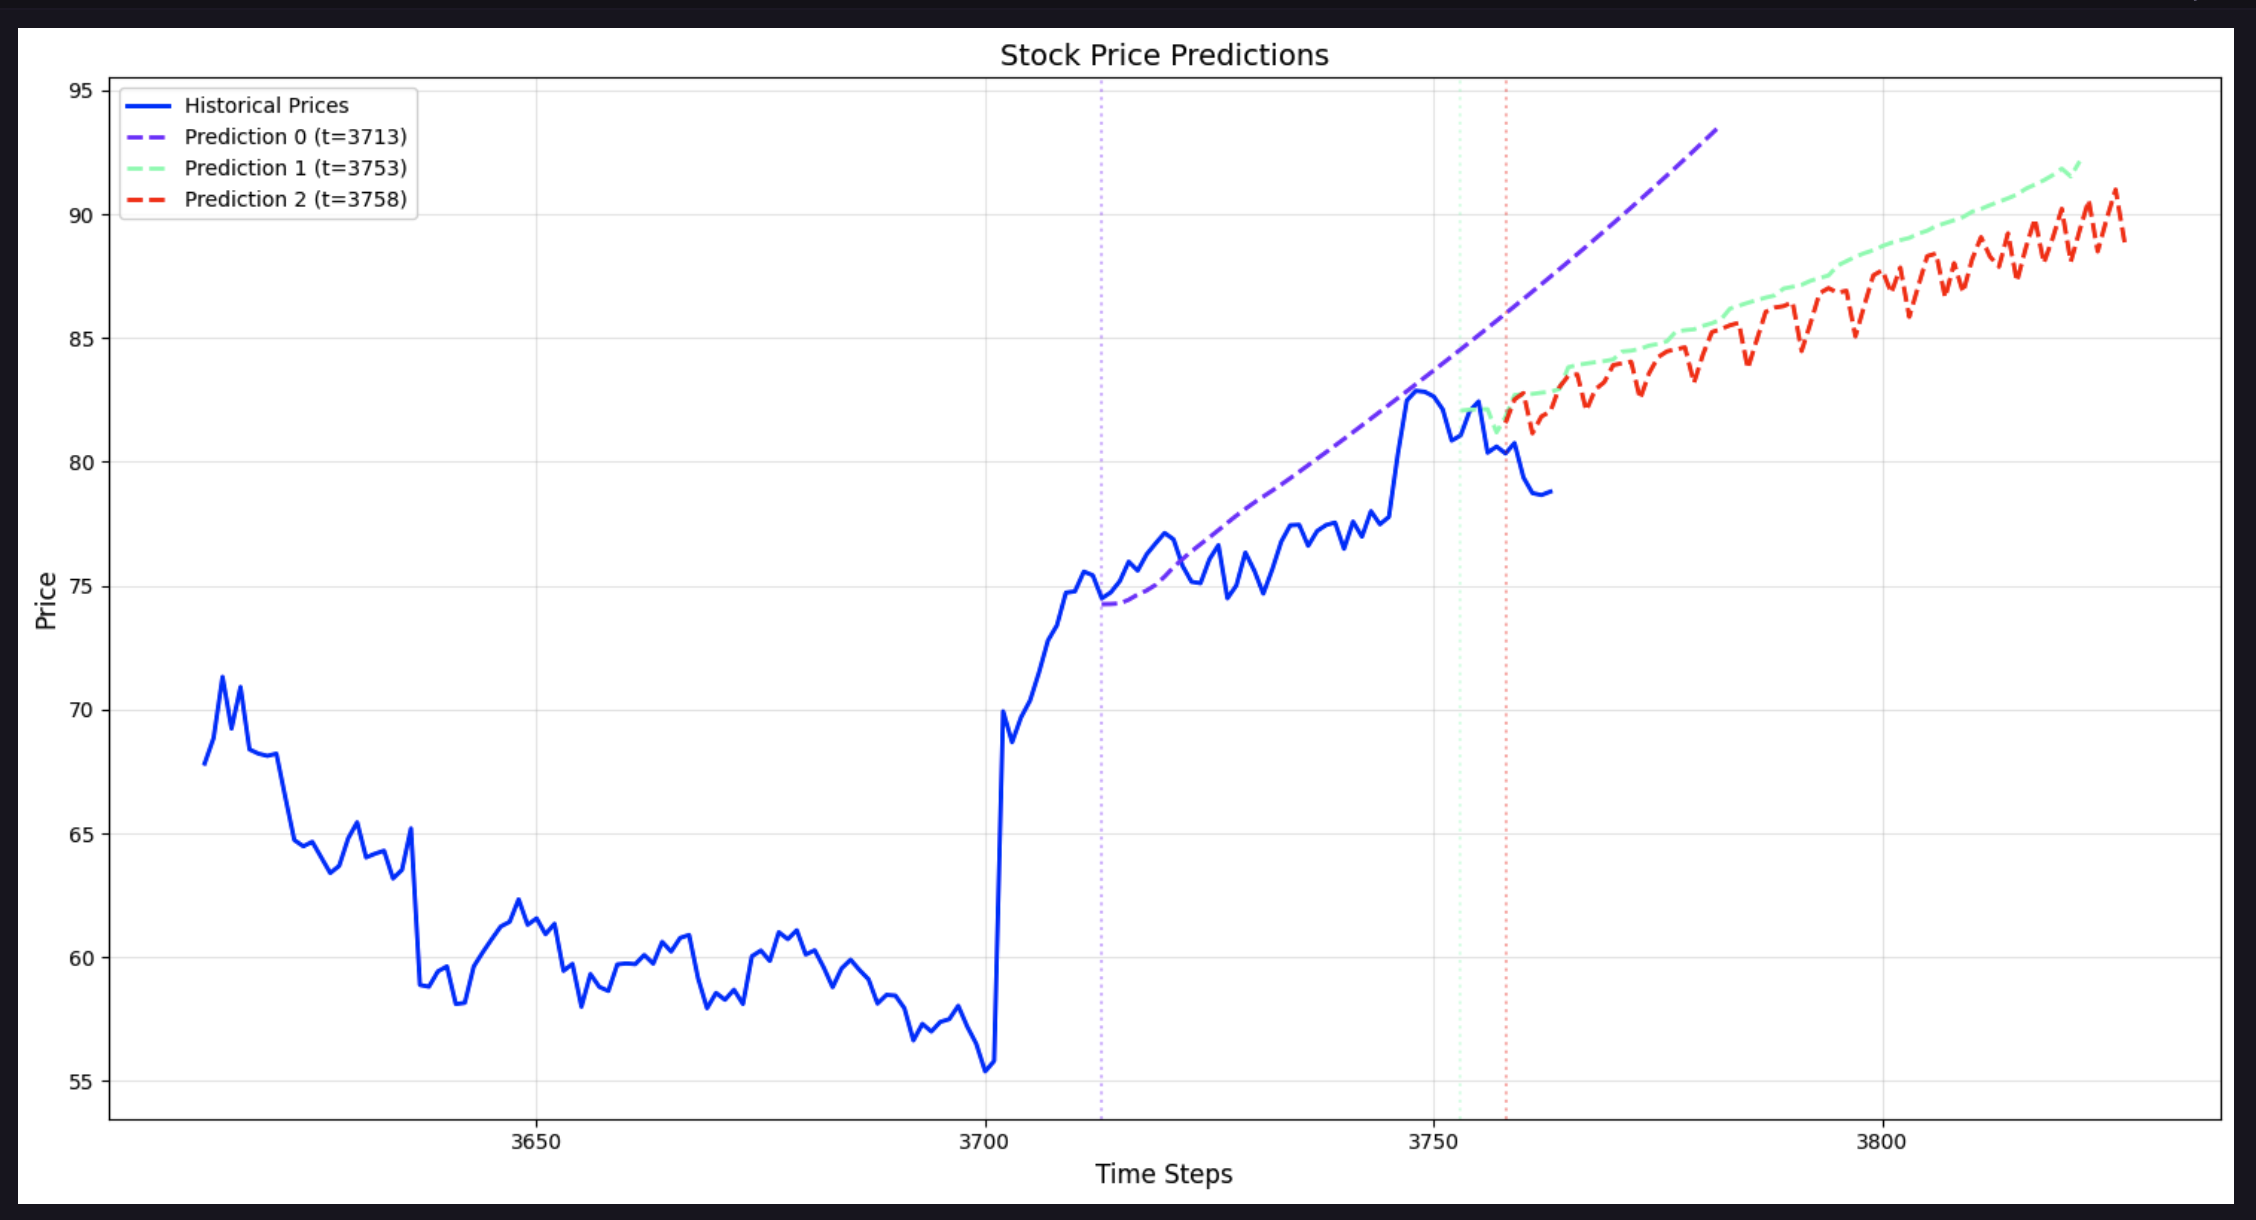

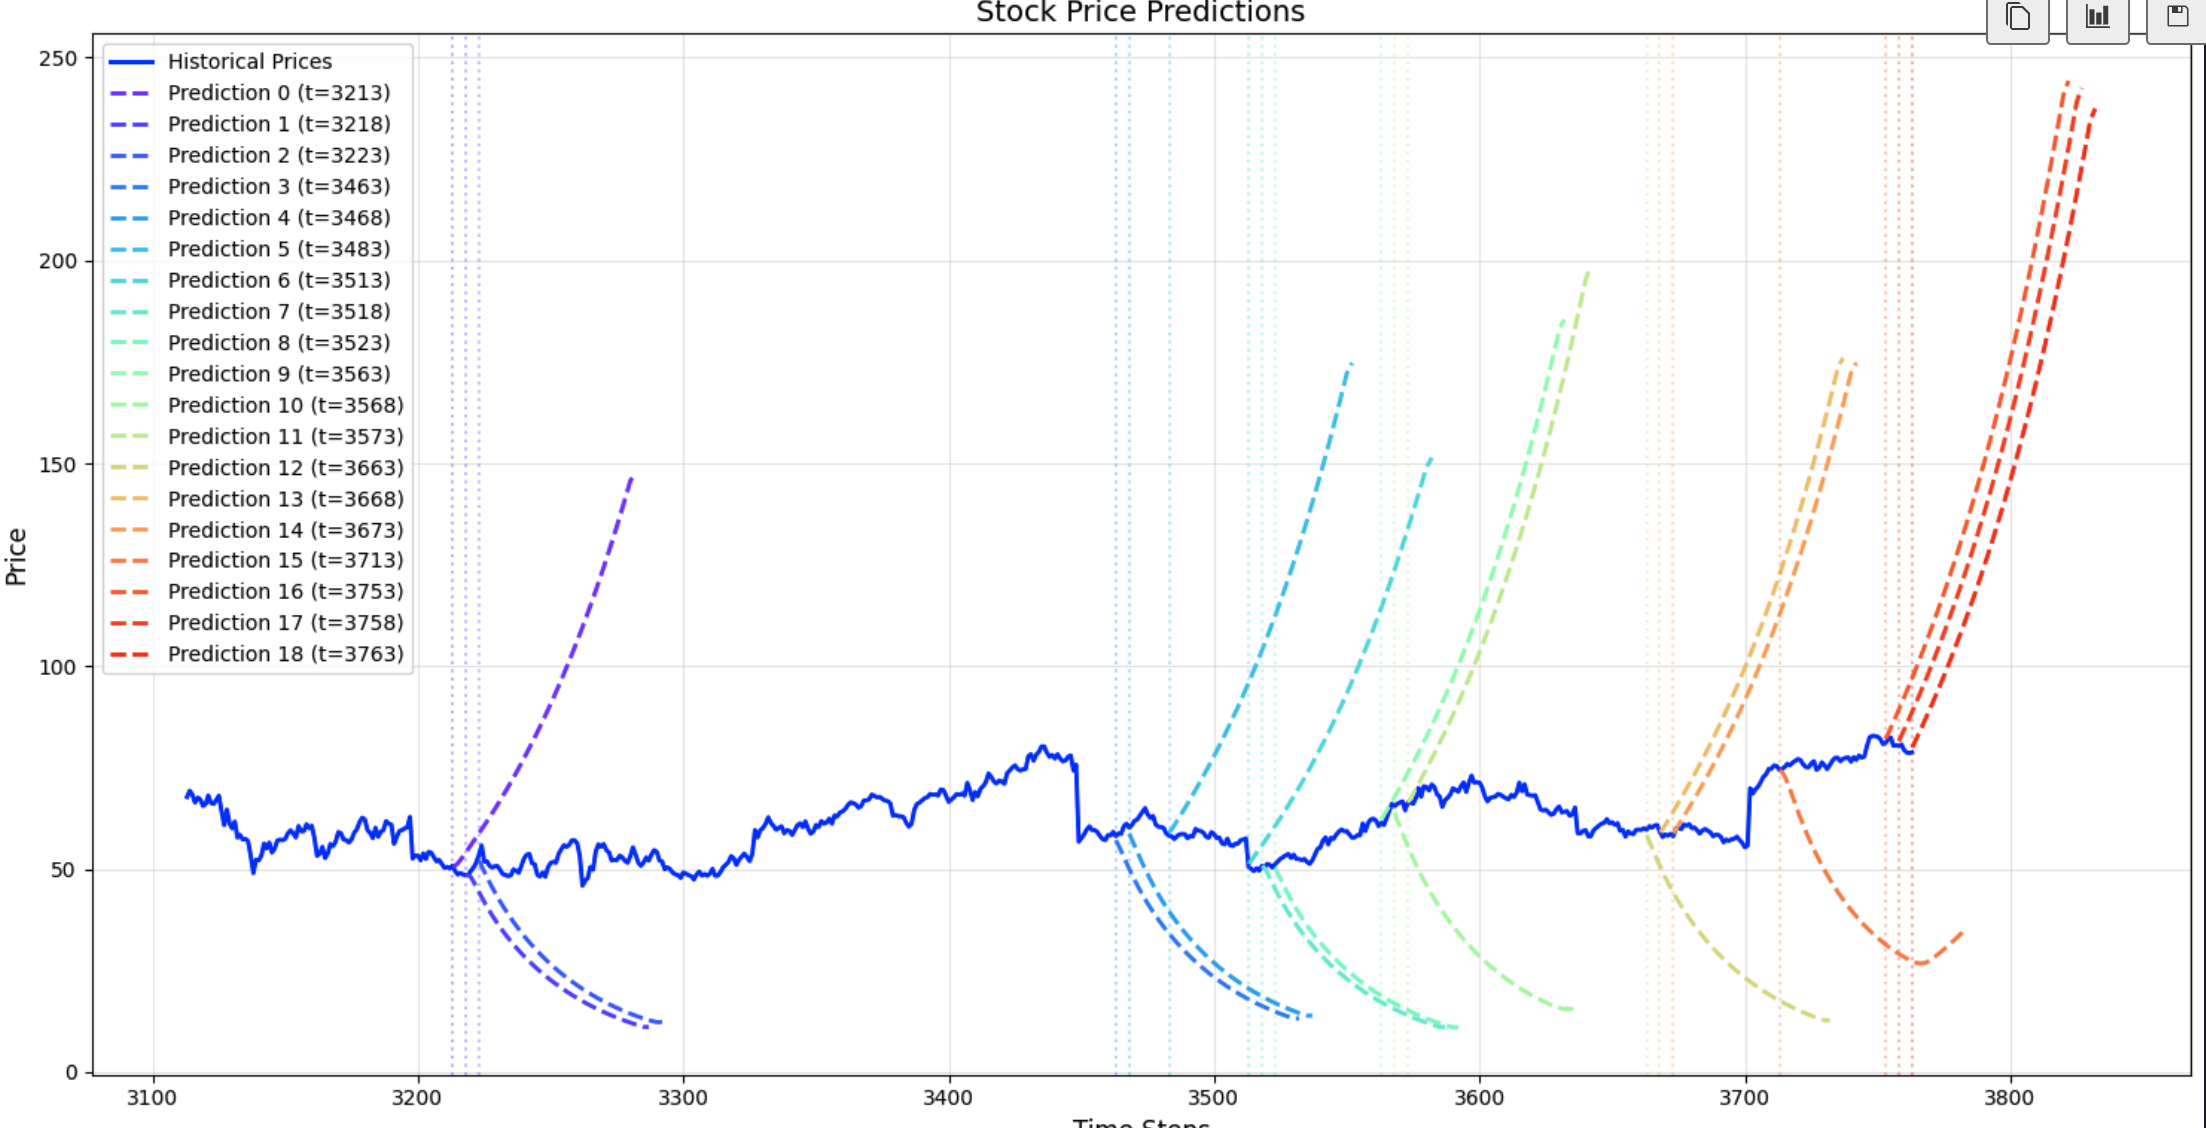

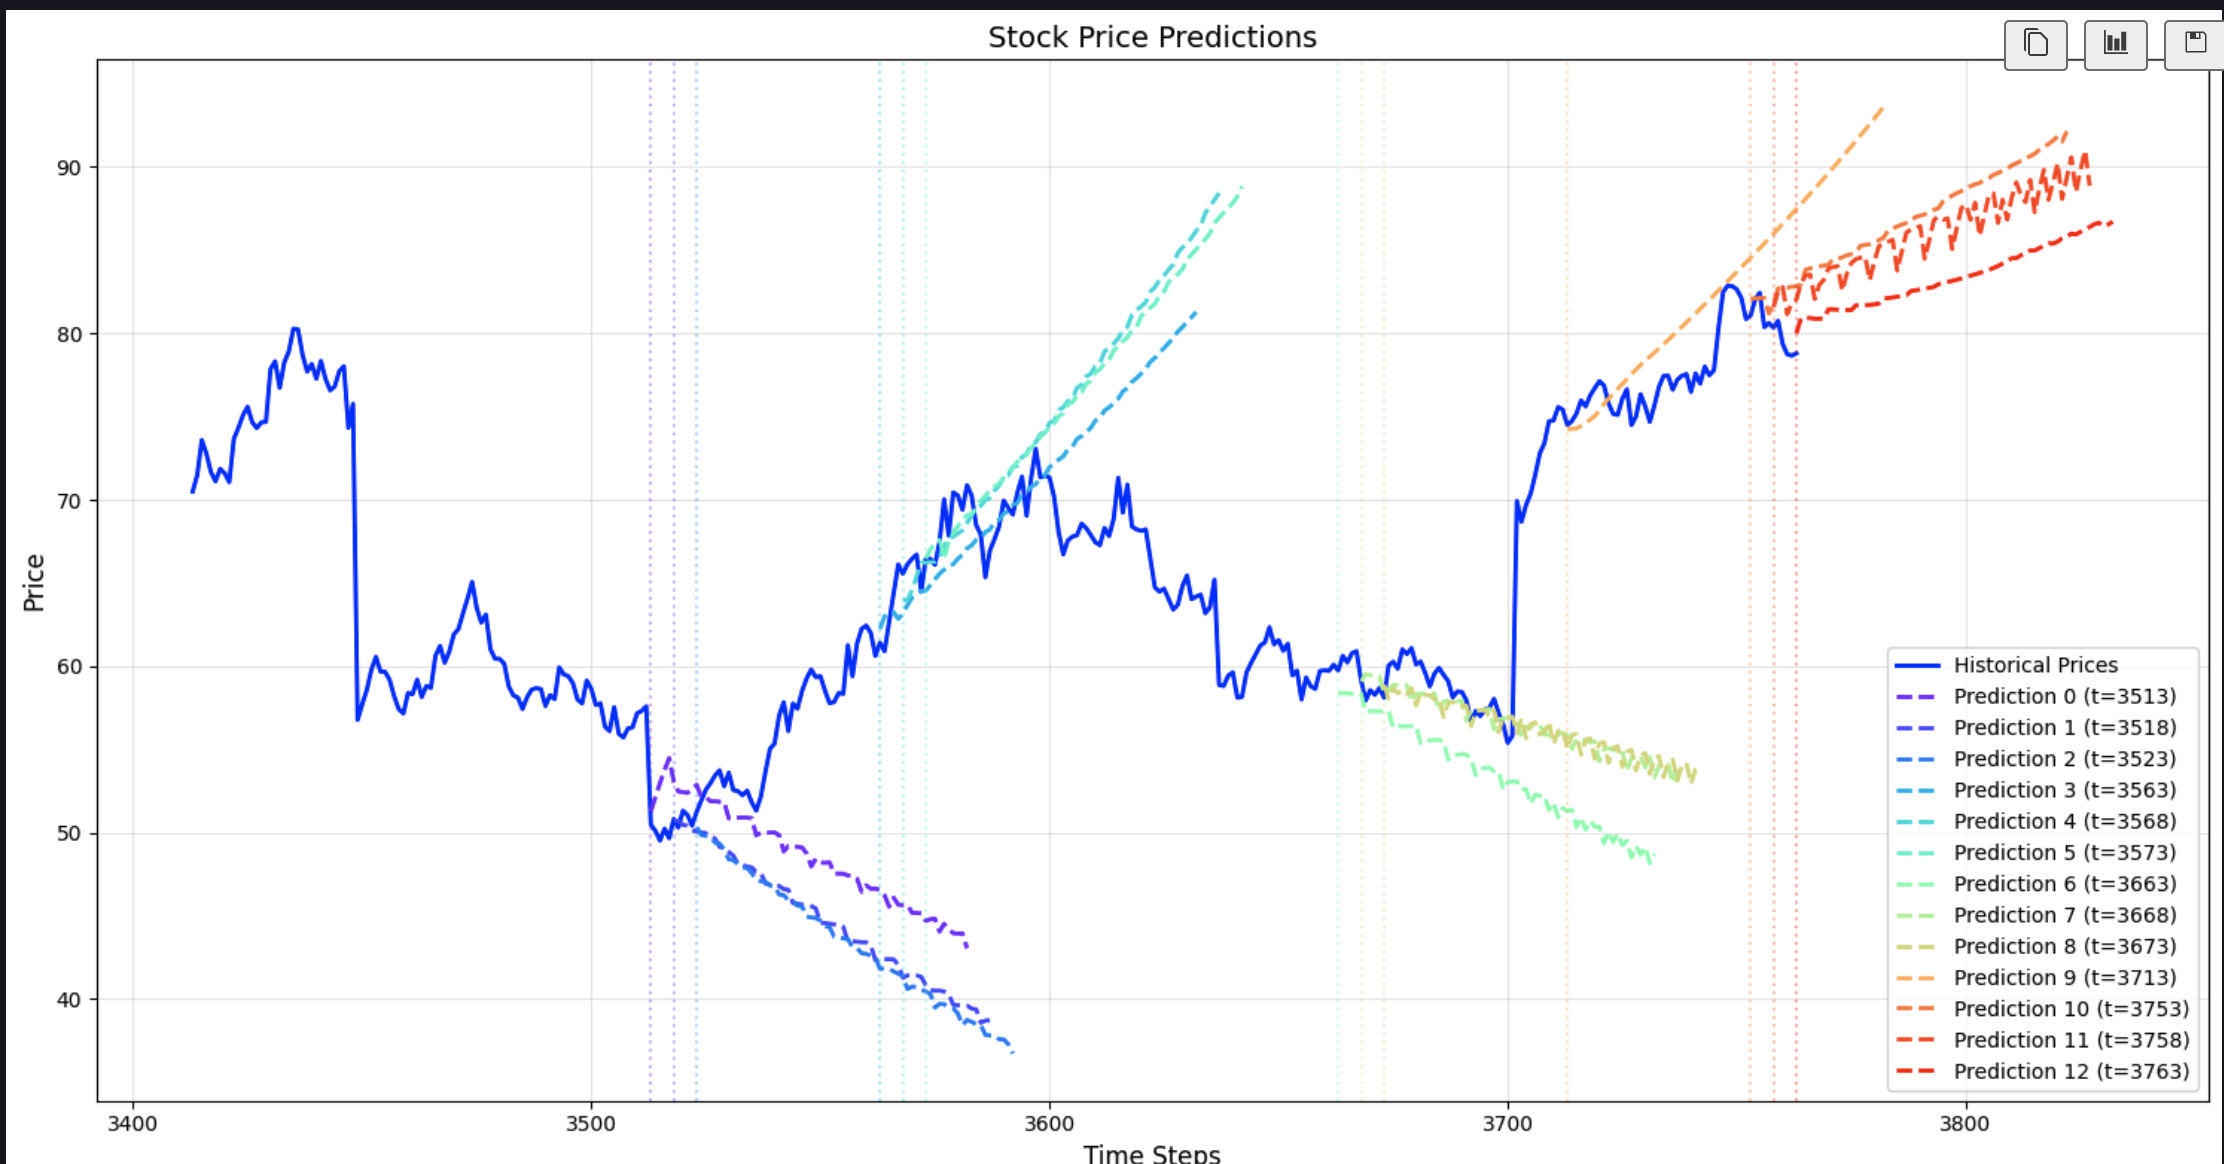